In [1]:
import netCDF4 as nc
import numpy as np
from datetime import datetime
import pandas as pd
import os
import geopandas as gpd
from functools import reduce

In [2]:
# Define paths and directories
directory = '/scratch/fuaday/ncrb-models/soil-texture'
input_basin    = '/home/fuaday/scratch/ncrb-models/geofabric-outputs/ncrb-geofabric/ncrb_subbasins.shp'
#input_ddb      = '/home/fuaday/scratch/ncrb-models/MESH-ncrb/MESH_drainage_database.nc'
OUTPUT_SHAPEFILE = 'merged_soil_data_shapefile4.shp'
merged_gsde_soil_data = 'merged_gsde_soil_data.csv'
file_names = [
    'st_stats_CLAY1.csv', 'st_stats_CLAY2.csv',
    'st_stats_SAND1.csv', 'st_stats_SAND2.csv',
    'st_stats_BD1.csv', 'st_stats_BD2.csv',
    'st_stats_OC1.csv', 'st_stats_OC2.csv'
]
file_paths = [os.path.join(directory, filename) for filename in file_names]

# Load and merge CSV files
def load_and_merge_files(file_list, key='COMID'):
    dfs = [pd.read_csv(fp) for fp in file_list]
    return reduce(lambda left, right: pd.merge(left, right, on=key, how='outer'), dfs)

gsde_df = load_and_merge_files(file_paths)

In [3]:
# Lists for search and replacement
searchname = ['_depth=4.5', '_depth=9.1000004', '_depth=16.6', '_depth=28.9', '_depth=49.299999', '_depth=82.900002', '_depth=138.3', '_depth=229.60001']
replacename = ['1', '2', '3', '4', '5', '6', '7', '8']

# Replace column names and remove periods
new_columns = []
for column in gsde_df.columns:
    for search, replace in zip(searchname, replacename):
        if search in column:
            column = column.replace(search, replace)
    column = column.replace('.', '')  # This line removes periods from column names
    new_columns.append(column)

gsde_df.columns = new_columns

#print(gsde_df.columns)

In [4]:
# Fill missing data using forward and backward fill sorted based on COMID
# Replace values greater than 100 with NaN, excluding 'COMID' and columns containing 'OC' or 'BD'
for col in gsde_df.columns:
    if col != 'COMID' and 'OC' not in col and 'BD' not in col:  # Exclude 'COMID', and columns with 'OC' or 'BD'
        gsde_df.loc[gsde_df[col] > 100, col] = np.nan

# Sort by COMID for logical filling
gsde_df.sort_values('COMID', inplace=True)

# Fill missing values using forward and backward filling
gsde_df.fillna(method='ffill', inplace=True)  # Forward fill
gsde_df.fillna(method='bfill', inplace=True)  # Backward fill if any NA still exists after ffill

# Optionally, check the result to confirm that no more NAs exist
print(gsde_df.isna().sum())

COMID        0
meanCLAY1    0
meanCLAY2    0
meanCLAY3    0
meanCLAY4    0
            ..
minOC8       0
maxOC5       0
maxOC6       0
maxOC7       0
maxOC8       0
Length: 97, dtype: int64


In [5]:
# Depth intervals
gsde_intervals = [(0, 0.045), (0.045, 0.091), (0.091, 0.166), (0.166, 0.289), 
                  (0.289, 0.493), (0.493, 0.829), (0.829, 1.383), (1.383, 2.296)]
mesh_intervals = [(0, 0.1), (0.1, 0.35), (0.35, 1.2), (1.2, 4.1)]

# Calculate weights
def calculate_weights(gsde_intervals, mesh_intervals):
    weights_used = []
    for mesh_interval in mesh_intervals:
        start, end = mesh_interval
        weights = []
        for gsde_interval in gsde_intervals:
            gsde_start, gsde_end = gsde_interval
            overlap_start = max(start, gsde_start)
            overlap_end = min(end, gsde_end)
            weight = (overlap_end - overlap_start) / (end - start) if overlap_start < overlap_end else 0
            weights.append(weight)
        weights_used.append([w / sum(weights) for w in weights if sum(weights) > 0])
    return weights_used

weights_used = calculate_weights(gsde_intervals, mesh_intervals)
print(weights_used)

[[0.44999999999999996, 0.45999999999999996, 0.09000000000000008, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.26400000000000007, 0.49199999999999994, 0.24400000000000002, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.1682352941176471, 0.3952941176470588, 0.4364705882352941, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.1669708029197081, 0.8330291970802919]]


In [6]:
# Define column names for each soil property
# properties = ['CLAY', 'SAND', 'BD', 'OC']
# depths = ['4.5', '9.1000004', '16.6', '28.9', '49.299999', '82.900002', '138.3', '229.60001']
# column_names = {prop: [f'mean.{prop}_depth={depth}' for depth in depths] for prop in properties}
properties = ['CLAY', 'SAND', 'BD', 'OC']
depths = ['1', '2', '3', '4', '5', '6', '7', '8']
column_names = {prop: [f'mean{prop}{depth}' for depth in depths] for prop in properties}
print(column_names)
# Extract and calculate weighted sums directly into gsde_df
for prop, cols in column_names.items():
    #extracted_data = gsde_df[cols].fillna(0)  # Handle missing values
    extracted_data = gsde_df[cols]  # Handle missing values
    #print(extracted_data)
    weights_array = np.array(weights_used).T  # Transpose to align for dot product
    print(weights_array)
    mesh_values = np.dot(extracted_data, weights_array)
    # Apply conversion factor specifically for OC
    if prop == 'OC':
        mesh_values *= 0.01 * 1.72
    for i, mesh_col in enumerate([f'mesh{prop}{j+1}' for j in range(len(mesh_intervals))]):
        gsde_df[mesh_col] = mesh_values[:, i]


#print(gsde_df[['meshCLAY1', 'meshCLAY2', 'meshCLAY3', 'meshCLAY4']].head()) # Check results
gsde_df.to_csv(os.path.join(directory, merged_gsde_soil_data), index=False) # Save DataFrame if needed

{'CLAY': ['meanCLAY1', 'meanCLAY2', 'meanCLAY3', 'meanCLAY4', 'meanCLAY5', 'meanCLAY6', 'meanCLAY7', 'meanCLAY8'], 'SAND': ['meanSAND1', 'meanSAND2', 'meanSAND3', 'meanSAND4', 'meanSAND5', 'meanSAND6', 'meanSAND7', 'meanSAND8'], 'BD': ['meanBD1', 'meanBD2', 'meanBD3', 'meanBD4', 'meanBD5', 'meanBD6', 'meanBD7', 'meanBD8'], 'OC': ['meanOC1', 'meanOC2', 'meanOC3', 'meanOC4', 'meanOC5', 'meanOC6', 'meanOC7', 'meanOC8']}
[[0.45       0.         0.         0.        ]
 [0.46       0.         0.         0.        ]
 [0.09       0.264      0.         0.        ]
 [0.         0.492      0.         0.        ]
 [0.         0.244      0.16823529 0.        ]
 [0.         0.         0.39529412 0.        ]
 [0.         0.         0.43647059 0.1669708 ]
 [0.         0.         0.         0.8330292 ]]
[[0.45       0.         0.         0.        ]
 [0.46       0.         0.         0.        ]
 [0.09       0.264      0.         0.        ]
 [0.         0.492      0.         0.        ]
 [0.         0

In [9]:
gsde_df

,COMID,meanCLAY1,meanCLAY2,meanCLAY3,meanCLAY4,minCLAY1,minCLAY2,minCLAY3,minCLAY4,maxCLAY1,...,meshSAND3,meshSAND4,meshBD1,meshBD2,meshBD3,meshBD4,meshOC1,meshOC2,meshOC3,meshOC4
0,71000022,14.000001,14.000001,13.000001,12.000001,14.0,14.0,13.0,12.0,14.0,...,69.745882,59.504565,105.660000,115.168006,125.568246,129.000015,15.553272,16.632745,13.817348,2.047663
1,71000023,14.000000,14.000000,13.000000,12.000001,14.0,14.0,13.0,12.0,14.0,...,69.745882,59.504562,105.660000,115.168000,125.568235,129.000000,15.553272,16.632744,13.817347,2.047663
2,71000024,14.000000,14.000000,12.999999,12.000000,14.0,14.0,13.0,12.0,14.0,...,69.745882,59.504562,105.660000,115.167998,125.568234,129.000000,15.553272,16.632744,13.817347,2.047663
3,71000025,14.000000,14.000000,13.000000,12.000000,14.0,14.0,13.0,12.0,14.0,...,69.745882,59.504562,105.660001,115.168002,125.568235,129.000000,15.553272,16.632744,13.817347,2.047663
4,71000026,13.999999,13.999999,12.999999,11.999999,14.0,14.0,13.0,12.0,14.0,...,69.745882,59.504562,105.659993,115.167996,125.568232,129.000000,15.553271,16.632743,13.817346,2.047663
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
32271,71048949,14.185483,14.185483,14.378451,14.012867,11.0,11.0,11.0,10.0,23.0,...,56.422220,61.992500,140.382696,145.232099,157.468811,157.090575,2.992510,2.419853,0.690038,0.353995
32272,71048950,28.306269,28.538778,28.771284,28.788483,13.0,13.0,13.0,13.0,29.0,...,33.837573,35.690316,146.807196,153.329255,170.355556,171.666794,5.688066,4.483270,1.076472,0.469757
32273,71048951,24.647860,25.107819,25.567774,27.627327,19.0,19.0,19.0,19.0,29.0,...,36.949702,41.843392,135.672051,144.785099,160.862140,163.971995,4.832621,3.561028,0.790577,0.432986
32274,71050686,21.000000,22.000000,22.000000,23.000000,21.0,22.0,22.0,23.0,21.0,...,41.536471,19.675182,124.730000,133.368000,148.131765,148.500912,5.422300,2.911478,0.548882,0.352647


In [10]:
# Load and prepare shapefile
gdf = gpd.read_file(input_basin).to_crs(epsg=4326)
gdf['COMID'] = gdf['COMID'].astype(int)

# Merge DataFrame with GeoDataFrame based on 'COMID'
merged_gdf = gdf.merge(gsde_df, on='COMID', how='left')

# Save the merged GeoDataFrame to a shapefile
output_shapefile = os.path.join(directory, OUTPUT_SHAPEFILE)
merged_gdf.to_file(output_shapefile)

In [11]:
#print(gsde_df[['meshCLAY1', 'meshCLAY2', 'meshCLAY3', 'meshCLAY4']].head())

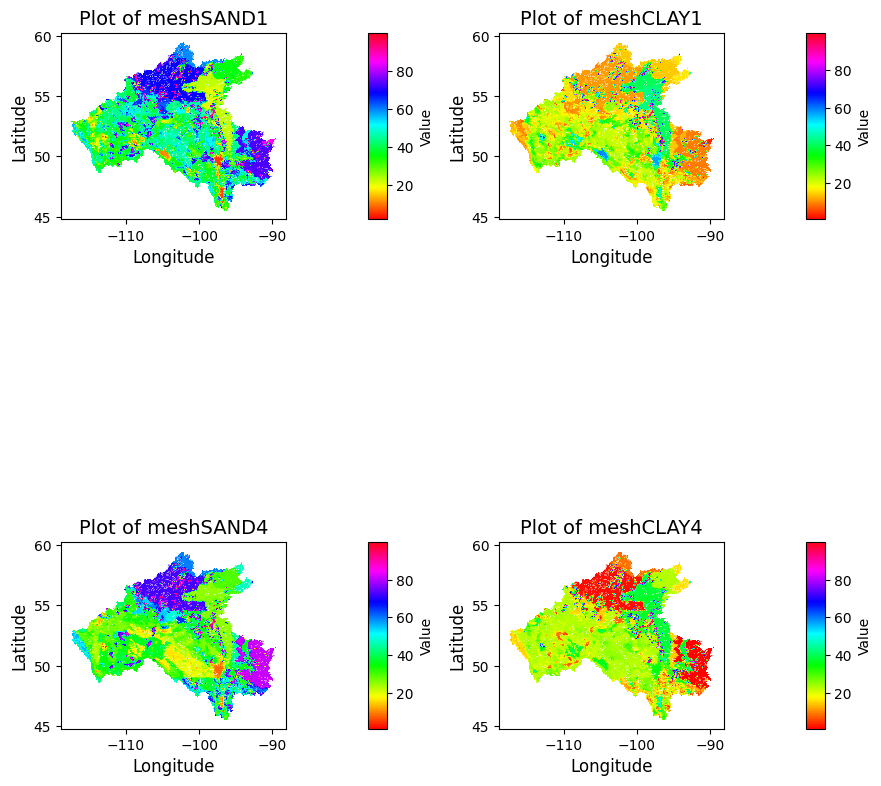

In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

# Assuming merged_gdf is your GeoDataFrame already loaded with necessary columns

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
columns_to_plot = ['meshSAND1', 'meshCLAY1', 'meshSAND4', 'meshCLAY4']
cmap = plt.cm.get_cmap('hsv')

# Plot each column in its respective subplot
for ax, column in zip(axes.flatten(), columns_to_plot):
    # Plotting the column
    prec_mapping = merged_gdf.plot(column=column, ax=ax, legend=False, 
                                   vmin=merged_gdf[column].min(), vmax=merged_gdf[column].max(), 
                                   cmap=cmap)
    # Setting individual axis labels
    ax.set_xlabel('Longitude', fontsize=12)  # Adjust as needed
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title(f'Plot of {column}', fontsize=14)

    # Create colorbar for each subplot individually using make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.1)
    colorbar = plt.colorbar(prec_mapping.get_children()[0], cax=cax)
    colorbar.set_label('Value')  # You can customize this label appropriately

fig.tight_layout(pad=1.0)  # Adjust subplots to fit into figure area.
fig.subplots_adjust(right=0.85, hspace=0.1, wspace=0.1)
plt.show()


# Adjust layout
#fig.tight_layout(pad=1.0)
#fig.subplots_adjust(right=0.85, hspace=0.1, wspace=0.1)


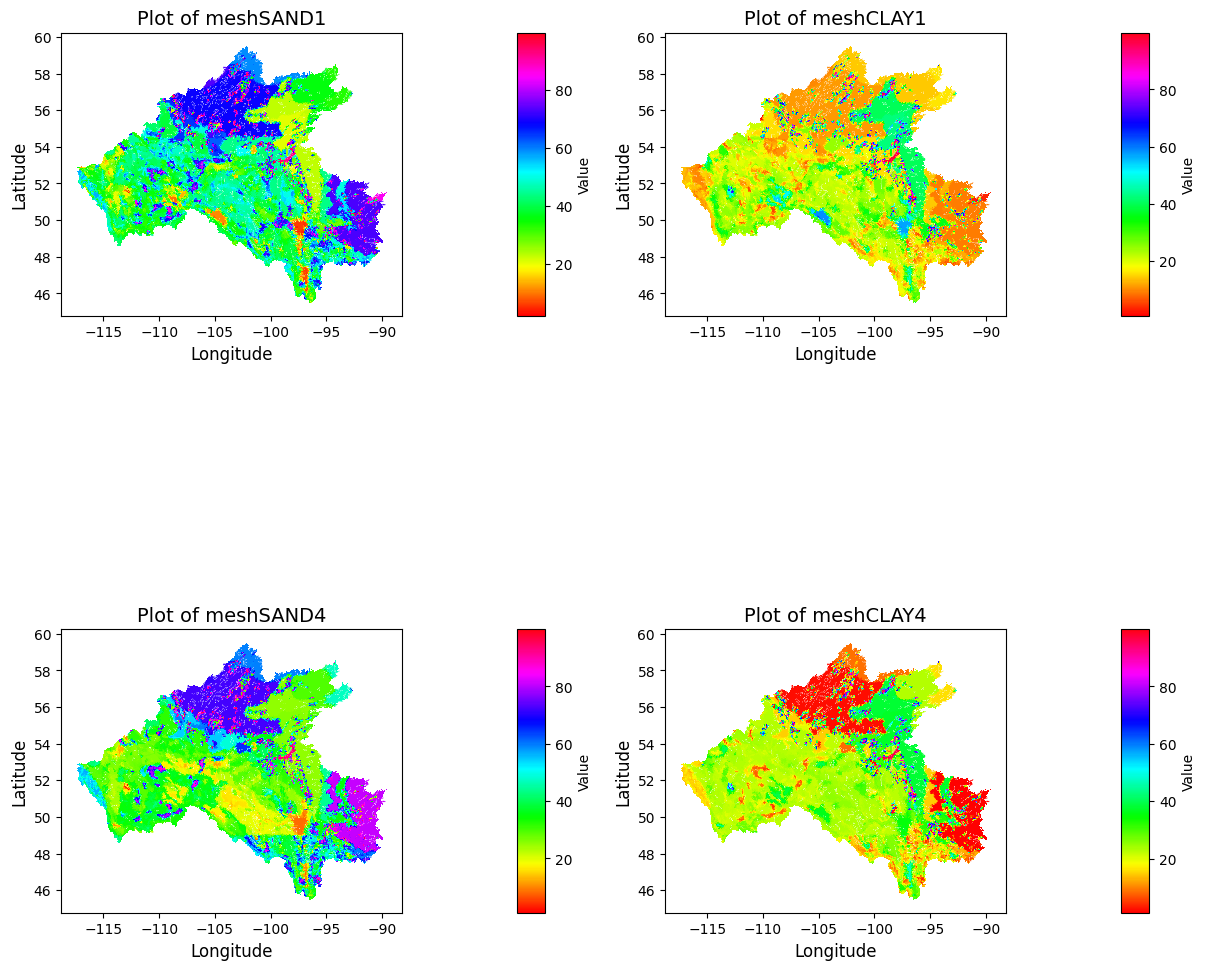

In [17]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import geopandas as gpd

# Assuming merged_gdf is your GeoDataFrame already loaded with necessary columns

fig, axes = plt.subplots(2, 2, figsize=(15, 15))
columns_to_plot = ['meshSAND1', 'meshCLAY1', 'meshSAND4', 'meshCLAY4']
cmap = plt.cm.get_cmap('hsv')

# Plot each column in its respective subplot
for ax, column in zip(axes.flatten(), columns_to_plot):
    # Plotting the column
    prec_mapping = merged_gdf.plot(column=column, ax=ax, legend=False, 
                                   vmin=merged_gdf[column].min(), vmax=merged_gdf[column].max(), 
                                   cmap=cmap)
    # Setting individual axis labels
    ax.set_xlabel('Longitude', fontsize=12)  # Adjust as needed
    ax.set_ylabel('Latitude', fontsize=12)
    ax.set_title(f'Plot of {column}', fontsize=14)

    # Create colorbar for each subplot individually using make_axes_locatable
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Reduced padding
    colorbar = plt.colorbar(prec_mapping.get_children()[0], cax=cax)
    colorbar.set_label('Value')  # Customize this label appropriately

# Adjust layout
plt.subplots_adjust(left=0.05, right=0.85, top=0.95, bottom=0.05, wspace=0.15, hspace=0.15)
fig.tight_layout(rect=[0, 0, 0.85, 1])  # Adjust the rect parameter to make room for colorbars

plt.show()


In [ ]:
ncname = 'ncrb'
# Define the path and name for the netCDF file
ncfname = f"MESH_parameters_{ncname}.nc"

# Open a new netCDF file for writing
rootgrp = nc.Dataset(ncfname, "w", format="NETCDF4")

In [ ]:
# Define dimensions
subbasin_dim = rootgrp.createDimension("subbasin", len(input_basin['Rank']))
ngru_dim = rootgrp.createDimension("ngru", MaxNumGRUs)
nsol_dim = rootgrp.createDimension("nsol", num_soil_data)

# Define variables with their respective dimensions
lon_var = rootgrp.createVariable("lon", "f4", ("subbasin",), fill_value=-1.0)
lat_var = rootgrp.createVariable("lat", "f4", ("subbasin",), fill_value=-1.0)
time_var = rootgrp.createVariable("time", "f4", ("subbasin",), fill_value=-1.0)
clay_var = rootgrp.createVariable("clay", "f4", ("nsol", "subbasin"), fill_value=-1.0)
sand_var = rootgrp.createVariable("sand", "f4", ("nsol", "subbasin"), fill_value=-1.0)
orgm_var = rootgrp.createVariable("orgm", "f4", ("nsol", "subbasin"), fill_value=-1.0)
# Add more variables as needed...

# Assign attributes to variables
lon_var.units = "degrees_east"
lat_var.units = "degrees_north"
time_var.units = "days since 1980-10-01 00:00:00.0 -0:00"
clay_var.long_name = "Clay Content of Soil Layer"
sand_var.long_name = "Sand Content of Soil Layer"
orgm_var.long_name = "Organic Matter Content of Soil Layer"
# Add more attributes as needed...

# Assign data to variables
lon_var[:] = np.transpose(np.array(input_basin['xcentroid']))
lat_var[:] = np.transpose(np.array(input_basin['ycentroid']))
time_var[:] = np.zeros(len(input_basin['Rank']))  # Assuming time is set to 0
# Add more data assignments as needed...

# Assign global attributes
rootgrp.Conventions = "CF-1.0"
rootgrp.source = "MERIT Hydro for DEM and COE for land cover"
rootgrp.institution = "https://gwf.usask.ca/"
rootgrp.references = "xx et al. (xxxx) journal xx:xx-xx"
rootgrp.history = f"Z.K. Tesemma, {datetime.now().strftime('%Y-%m-%d')}"
rootgrp.featureType = "point"

# Close the file to write data to disk
rootgrp.close()

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
# Plot Drainage area
viridis_r = plt.cm.get_cmap('hsv')#.reversed()
prec_mapping = merged_gdf.plot(column='meshSAND1', ax=ax, legend=False, vmin=merged_gdf['meshSAND1'].min(), vmax=merged_gdf['meshSAND1'].max(), cmap=viridis_r)
# Manually add colorbar axes with reduced height
cbar_ax = fig.add_axes([0.92, 0.15, 0.03, 0.65])  # Reduced height
colorbar = fig.colorbar(prec_mapping.get_children()[0], cax=cbar_ax, orientation='vertical')
#colorbar.set_label('Prec annual')
# Add axis labels and plot title
ax.set_xlabel('Longitude', fontsize=14)  # Assuming appropriate labels for geographic data
ax.set_ylabel('Latitude', fontsize=14)
#ax.set_title('Annual Precipitation', fontsize=14)
# Save the figure
#plt.savefig('AnnualPrecipitation.png', dpi=300)  # Adjust dpi for higher resolution
#plt.show()